In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error,make_scorer
import math
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 

<H2> Whats in this file <H2>
<H2>1. Pick features to model based on <H2>
<H2>a. variance, <H2>
<H2>b. correlation and <H2>
<H2>c. Sequential Feature Selector<H2>
<H2>d. decision tree based importances<H2>

In [24]:
turbine_data=pd.read_excel('interview data.xlsx')
turbine_data.columns=['TimeStamp','Generated watts','Exhaust temp','Comp Inlet Temp','Comp IGV angle','Comp discharge pressure','Comp discharge temp']
turbine_data.set_index('TimeStamp',inplace=True)

In [25]:
X=turbine_data.loc[:,'Exhaust temp':'Comp discharge temp']
y=turbine_data.loc[:,'Generated watts']

<H2>The distribution curves dont follow a bell curve. So we can standardize it to represent normal distribution<H2>

<H1> Accuracy computation for baseline <H1>

In [26]:
def accuracyScore():
    classifier_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    y_pred = cross_val_predict(classifier_pipeline,X,y, cv=10)
    print("R_squared: " + str(round(r2_score(y,y_pred),4)))
    print("RMSE: " + str(round(math.sqrt(mean_squared_error(y,y_pred)),4)))

In [27]:
accuracyScore()

R_squared: 0.9941
RMSE: 2.809


<H2> Filter features based on variance. Feature with low variance dont have much to attribute. <H2>

In [28]:
var_matrix=turbine_data.var()
var_matrix

Generated watts              1326.499200
Exhaust temp               218866.877695
Comp Inlet Temp               120.461556
Comp IGV angle                578.055854
Comp discharge pressure      5594.824188
Comp discharge temp         72611.282716
dtype: float64

<H2> Even from previous correlation heat map; Comp Inlet temp had low correlation with other features. 
Checking for improvement in score by removing it.<H2>

In [21]:
low_variance_features=var_matrix[var_matrix<200].index.to_list()

In [29]:
X=X.drop(columns=low_variance_features)

In [30]:
accuracyScore()

R_squared: 0.9941
RMSE: 2.8052


In [31]:
corr_matrix=turbine_data.drop(columns=low_variance_features).corr(method='kendall')

In [32]:
(corr_matrix['Generated watts'].drop('Generated watts')).sort_values(ascending=False)

Comp discharge pressure    0.686498
Comp IGV angle             0.625665
Comp discharge temp        0.463505
Exhaust temp               0.455276
Name: Generated watts, dtype: float64

<H2> The correlation values are really close, However I want to delete Comp Discharge temp as its highly correlated with Exhaust temp. Its also highly correlated with discharge pressure than exhaust pressure. I want to also remove Comp discharge temp just to check if it affects accuracy.<h2>


In [33]:
X=X.drop(columns=['Comp discharge temp','Comp discharge pressure'])

In [34]:
accuracyScore()

R_squared: 0.9903
RMSE: 3.583


<h2>I am going to further check using Sequential feature selection technique. <H2>

In [35]:
r2=make_scorer(r2_score)
k=X.shape[1]
classifier_pipeline = make_pipeline(StandardScaler(), LinearRegression())
sfs=SFS(classifier_pipeline,k_features=k,forward=True,scoring=r2,cv=10)

In [36]:
sfs=sfs.fit(X,y)
sfs.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([0.89463544, 0.98994526, 0.99349453, 0.98886654, 0.97866325,
         0.98797359, 0.98785642, 0.97649167, 0.9674164 , 0.92899714]),
  'avg_score': 0.9694340242814823,
  'feature_names': ('Comp IGV angle',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.96063117, 0.98785591, 0.98758537, 0.99229234, 0.97648094,
         0.98988148, 0.9881587 , 0.98541081, 0.98037436, 0.96061342]),
  'avg_score': 0.9809284490886825,
  'feature_names': ('Exhaust temp', 'Comp IGV angle')}}

In [38]:
sfs_bward=SFS(classifier_pipeline,k_features=1,forward=False,scoring=r2,cv=10)
sfs_bward=sfs_bward.fit(X,y)
sfs_bward.subsets_

{2: {'feature_idx': (0, 1),
  'cv_scores': array([0.96063117, 0.98785591, 0.98758537, 0.99229234, 0.97648094,
         0.98988148, 0.9881587 , 0.98541081, 0.98037436, 0.96061342]),
  'avg_score': 0.9809284490886825,
  'feature_names': ('Exhaust temp', 'Comp IGV angle')},
 1: {'feature_idx': (1,),
  'cv_scores': array([0.89463544, 0.98994526, 0.99349453, 0.98886654, 0.97866325,
         0.98797359, 0.98785642, 0.97649167, 0.9674164 , 0.92899714]),
  'avg_score': 0.9694340242814823,
  'feature_names': ('Comp IGV angle',)}}

<H1> For final step; ordering feature importances using decision tree <H1>

In [39]:
regressor=DecisionTreeRegressor()
X=turbine_data.loc[:,'Exhaust temp':'Comp discharge temp']
regressor.fit(X,y)   

DecisionTreeRegressor()

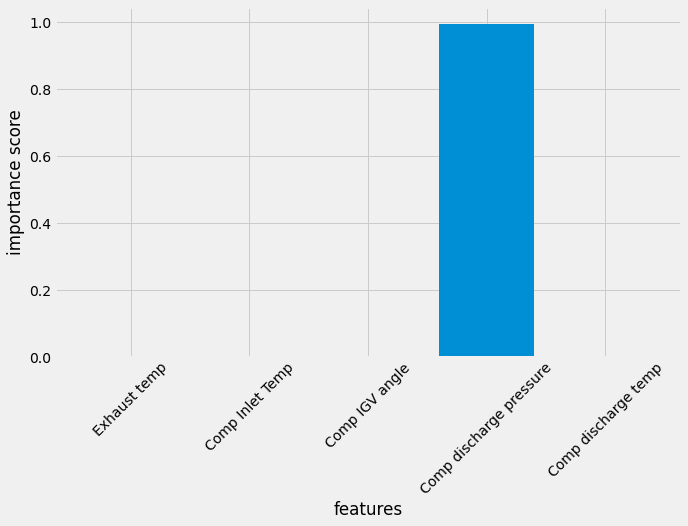

In [40]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
plt.bar(list(X.columns),list(regressor.feature_importances_))
plt.xlabel('features')
plt.ylabel('importance score')
plt.xticks(rotation=45)
plt.show()

<h2> So i bring back Comp discharge pressure <h2>

In [41]:
X=turbine_data.loc[:,['Exhaust temp','Comp discharge pressure','Comp IGV angle']]

In [42]:
accuracyScore()

R_squared: 0.9924
RMSE: 3.1731


<h2> This score and rmse is better than without comp discharge pressure <h2>